[View in Colaboratory](https://colab.research.google.com/github/Manelmc/rnn-time-to-event/blob/master/Turbofan%20Engine/predictive-maintenance-turbofan-engine.ipynb)

# Predictive Maintenance for Turbofan Engine Dataset


## Extract, Transform and Load

In [2]:
import keras
import keras.backend as K

print "Keras version", keras.__version__

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)  

Using TensorFlow backend.


Keras version 2.1.6


In [3]:
!mkdir Dataset

!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O Dataset/PM_test.txt 
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O Dataset/PM_train.txt  
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O Dataset/PM_truth.txt
  
!ls Dataset

PM_test.txt  PM_train.txt  PM_truth.txt


## Train Data

In [4]:
from sklearn import preprocessing

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('Dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df[train_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
187,1,188,0.114943,0.750000,0.0,0.0,0.765060,0.683235,0.684166,0.0,...,0.091599,0.753367,0.0,0.666667,0.0,0.0,0.286822,0.089202,4,0.518006
188,1,189,0.465517,0.666667,0.0,0.0,0.894578,0.547853,0.772451,0.0,...,0.090670,0.744132,0.0,0.583333,0.0,0.0,0.263566,0.301712,3,0.520776
189,1,190,0.344828,0.583333,0.0,0.0,0.731928,0.614345,0.737677,0.0,...,0.065229,0.759523,0.0,0.833333,0.0,0.0,0.271318,0.239299,2,0.523546
190,1,191,0.500000,0.166667,0.0,0.0,0.641566,0.682799,0.734639,0.0,...,0.075704,0.740669,0.0,0.500000,0.0,0.0,0.240310,0.324910,1,0.526316
191,1,192,0.551724,0.500000,0.0,0.0,0.701807,0.662089,0.758778,0.0,...,0.056714,0.717199,0.0,0.666667,0.0,0.0,0.263566,0.097625,0,0.529086


## Test Data

In [5]:
from sklearn import preprocessing

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[test_df["id"] == 1].tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
26,1,27,0.459770,0.583333,0.0,0.0,0.262048,0.340310,0.304862,0.0,...,0.140881,0.479030,0.0,0.333333,0.0,0.0,0.565891,0.688898,0.072022,116
27,1,28,0.626437,0.916667,0.0,0.0,0.216867,0.505995,0.321404,0.0,...,0.180359,0.469796,0.0,0.333333,0.0,0.0,0.534884,0.629660,0.074792,115
28,1,29,0.580460,0.583333,0.0,0.0,0.222892,0.351210,0.267725,0.0,...,0.171277,0.370527,0.0,0.333333,0.0,0.0,0.682171,0.646092,0.077562,114
29,1,30,0.356322,0.833333,0.0,0.0,0.475904,0.320035,0.316003,0.0,...,0.179843,0.331281,0.0,0.250000,0.0,0.0,0.736434,0.707954,0.080332,113
30,1,31,0.465517,0.833333,0.0,0.0,0.412651,0.221932,0.281229,0.0,...,0.155692,0.298192,0.0,0.416667,0.0,0.0,0.519380,0.636564,0.083102,112


### Generate Sequences

In [6]:
from sklearn.model_selection import train_test_split

def pad_sequence(df, max_seq_length):
    """
    Applies right padding to a sequences until max_seq_length with 0's
    """
    return np.pad(df.values, ((0, max_seq_length - df.values.shape[0]), (0,0)), "constant")
  
def pad_engines(df, cols, max_batch_len):
    """
    Applies right padding to the columns "cols" of all the engines 
    """
    return np.array([pad_sequence(df[df['id'] == batch_id][cols], max_batch_len) 
                     for batch_id in df['id'].unique()])
  
max_batch_len = train_df['id'].value_counts().max()
train_cols = ['s' + str(i) for i in range(1,22)] + ['setting1', 'setting2', 'setting3', 'cycle_norm']
test_cols = ["RUL"]

X = pad_engines(train_df, train_cols, max_batch_len)
Y = pad_engines(train_df, test_cols, max_batch_len)

# Split into train and validation
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.20, random_state=SEED)

# Test set from CMAPSS
test_X = pad_engines(test_df, train_cols, max_batch_len)
test_Y = pad_engines(test_df, test_cols, max_batch_len)

# In the WTTE-RNN architecture we will predict 2 parameters (alpha and beta)
# alpha is initialised to 1
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=2)
val_Y_wtte = np.concatenate((val_Y, np.ones(val_Y.shape)), axis=2)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=2)

print "Train:\n", "  X:", train_X.shape, "\n  Y:", train_Y.shape, "\n  Y_wtte:", train_Y_wtte.shape
print "\nValidation:\n", "  X:", val_X.shape, "\n  Y:", val_Y.shape, "\n  Y_wtte:", val_Y_wtte.shape
print "\nTest:\n", "  X:", test_X.shape, "\n  Y:", test_Y.shape, "\n  Y_wtte:", test_Y_wtte.shape

Train:
  X: (80, 362, 25) 
  Y: (80, 362, 1) 
  Y_wtte: (80, 362, 2)

Validation:
  X: (20, 362, 25) 
  Y: (20, 362, 1) 
  Y_wtte: (20, 362, 2)

Test:
  X: (100, 362, 25) 
  Y: (100, 362, 1) 
  Y_wtte: (100, 362, 2)


## Baseline

In [0]:
# "axis=-1" in original keras implementation gives problems 
# with the shape of the data 

def r2_keras(y_true, y_pred):
    """
    Coefficient of Determination 
    """
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def mse_keras(y_true, y_pred):
    """
    Mean Squared Error
    """
    return K.mean(K.square(y_true - y_pred))
  
def mae_keras(y_true, y_pred):
    """
    Mean Absolute Error
    """
    return K.mean(K.abs(y_pred - y_true))
  
keras.metrics.r2_keras = r2_keras
keras.metrics.mse_keras = mse_keras
keras.metrics.mae_keras = mae_keras

In [0]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = train_X.shape[2]
nb_out = train_Y.shape[2]
# Model path
baseline_path = "baseline_model"

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(max_batch_len, nb_features)))

model.add(LSTM(
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(LSTM(
         units=50,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(TimeDistributed(Dense(1, activation=K.exp)))
model.compile(loss="mse", optimizer=keras.optimizers.RMSprop())

print(model.summary())

# fit the network
history = model.fit(train_X, train_Y, epochs=500, batch_size=16, validation_data=(val_X, val_Y), shuffle=True, verbose=2, 
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(baseline_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                      ]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_11 (Masking)         (None, 362, 25)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 362, 100)          50400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 362, 50)           30200     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 362, 1)            51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 80 samples, validate on 20 samples
Epoch 1/500
 - 15s - loss: 24012.9434 - mean_absolute_error: 94.9381 - r2_keras: -4.8104e-01 - val_loss: 8061.9489 - val_mean_absolute_error: 74.8683 - val_r2_keras: -1.9506e+00
Epoch 2/500
 - 12s - loss: 11752.9648 - mea

In [0]:
# Execute if training in Colaboratory (preferably from Chrome)

from google.colab import files
files.download(baseline_path)

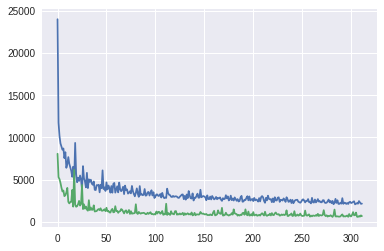

In [0]:
%matplotlib inline

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
model.evaluate(train_X, train_Y)

80/80 [==============================] - 2s 26ms/step


[1281.7427734375, 22.308277893066407, 0.8685529232025146]

In [0]:
model.evaluate(train_X, train_Y)

80/80 [==============================] - 3s 34ms/step


[1105.45361328125, 21.529032897949218, 0.8856462955474853]

In [0]:
from keras.models import load_model
#model = load_model("Models/regression_model.h5")
model = load_model(baseline_path, custom_objects={"exp": K.exp})

### Checking Keras implementation of scores

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(test_X)
val_mse, val_mae, val_r2 = model.evaluate(train_X, train_Y)

print "R Squared:\n  ", r2_score(test_Y.flatten(), y_pred.flatten()), val_r2
print "MAE:\n  ", mean_absolute_error(test_Y.flatten(), y_pred.flatten()), "vs", val_mae
print "MSE:\n  ", mean_squared_error(test_Y.flatten(), y_pred.flatten()), "vs", val_mse

80/80 [==============================] - 2s 26ms/step
R Squared:
   -0.02745649228230329 -0.005327702034264803
MAE:
   70.21962200986746 vs 64.77431945800781
MSE:
   6025.283887167654 vs 5664.56044921875


(36200,)
[154.76712  203.87921  207.69229  ...  26.214205  25.276253  23.090624]
0.5977930583488209
27.274495792083066
1399.0318918285627


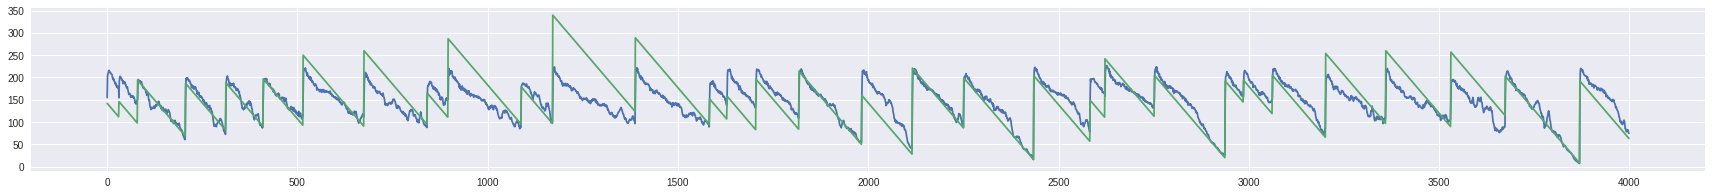

In [0]:
%matplotlib inline
# To validate we remove the right padding
l = test_Y.flatten()
y_pred = model.predict(test_X).flatten()
print l.shape
y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
# y_true = l
y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
print y_pred
print r2_score(y_true, y_pred)
print mean_absolute_error(y_true, y_pred)
print mean_squared_error(y_true, y_pred)
fig = plt.figure()
fig.add_subplot(1,1,1)
plt.plot(y_pred[0:4000])
plt.plot(y_true[0:4000])
fig.set_size_inches(30,3)

In [0]:

!ls Models

regression_model.h5  wtte_1_234.h5        wttwgru_1_35.h5
rnn_1_59.h5          wtte_no_dropout_1.h5
rnn_1_82.h5          wtte_no_dropout_2.h5


## WTTE

In [9]:
!pip install wtte

  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0


In [0]:
def r2_keras_(y_true, y_pred):
    """
    Coefficient of Determination 
    """
    SS_res =  K.sum(K.square(y_true - y_pred), axis=-1)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=-1)
    return 1 - SS_res/(SS_tot + K.epsilon())
  
def weibull_loglik_discrete(y_true, y_pred, epsilon=K.epsilon()):
    y = y_true[..., 0]
    u = y_true[..., 1]
    a = y_pred[..., 0]
    b = y_pred[..., 1]
    
    hazard0 = K.pow((y + epsilon) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)

    loss = u * K.log(K.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return -loss

"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(y_true, init_alpha=104., max_beta_value=10.):
    a = y_true[..., 0]
    b = y_true[..., 1]
    a = init_alpha * K.exp(a)
    b = K.sigmoid(b)
    return K.stack([a, b], axis=-1)
  
#keras.metrics.r2_keras = r2_keras

In [0]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed

import wtte.weibull as weibull
import wtte.wtte as wtte
from keras.layers import Lambda

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]
# Sample weights are necessary
train_X_batch_lengths = map(lambda x: x[~np.all(x == 0, axis=1)].shape[0], train_X)
batch_weights = np.array([[1.]*batch_len + [0.]*(max_batch_len - batch_len) for batch_len in train_X_batch_lengths])
# Initialization value for alpha
init_alpha = np.nanmean(train_Y_wtte[:,0])
# Model path
baseline_wtte_path = "baseline_wtte_model_weights"

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
from keras.layers import Masking
model.add(Masking(mask_value=0., input_shape=(None, nb_features)))

model.add(LSTM(
         input_shape=(None, nb_features),
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(LSTM(
          units=50,
          recurrent_dropout=0.2,
          return_sequences=True))
model.add(TimeDistributed(Dense(2)))
# model.add(Activation(activate))
model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value": 10.0
                           },
                ))
#model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop', metrics=[])
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function
model.compile(loss=loss, optimizer='rmsprop')# sample_weight_mode="temporal")

In [19]:
print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=500, batch_size=16, validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(baseline_wtte_path, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=0),
                       keras.callbacks.TerminateOnNaN()]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, None, 25)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 100)         50400     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2)           102       
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 2)           0         
Total params: 80,702
Trainable params: 80,702
Non-trainable params: 0
_________________________________________________________________
None
Train on 80 samples, validate on 20 samples
Epoch 1/500
 - 15s - loss: 4.3735 - val_loss: 3.7142
Epoch 2/500
 - 13s - loss: 3.8081 - 

In [0]:
# Execute if training in Colaboratory (preferably from Chrome)

from google.colab import files
files.download(baseline_wtte_path)

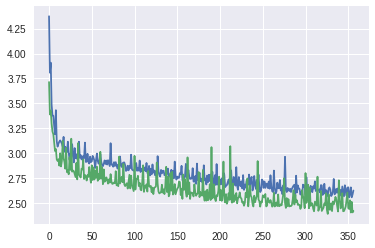

In [28]:
%matplotlib inline


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [35]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving baseline_wtte_model_weights (1) to baseline_wtte_model_weights (1)
User uploaded file "baseline_wtte_model_weights (1)" with length 340528 bytes


In [37]:
!ls

baseline_wtte_model_weights	 Dataset
baseline_wtte_model_weights (1)  sample_data


In [0]:
model.load_weights("baseline_wtte_model_weights (1)")

Train
20.94 & 33.14 & 0.772 \\
Validation
17.79 & 25.26 & 0.851 \\
Test
26.51 & 37.22 & 0.602 \\


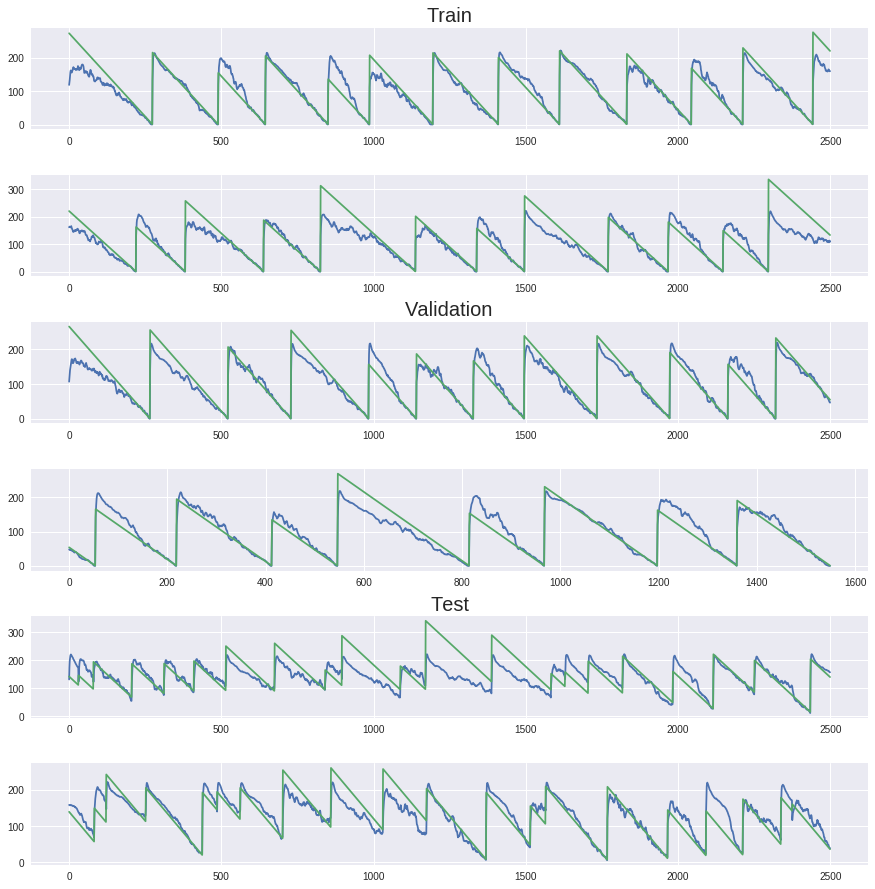

In [46]:
%matplotlib inline
from math import gamma, log, sqrt
from decimal import Decimal

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def cmapss_score(y_true, y_pred):
    acc = 0
    for y_true_t, y_pred_t in zip(y_true, y_pred):
        error = y_pred_t - y_true_t
        acc += np.e**-(error/10) - 1 if error < 0 else np.e**(error/13) - 1
    return acc

def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha) if alpha > 1 else 0

def median_weibull(alpha, beta):
    return beta*(log(2)**(1./alpha))

fig = plt.figure()
i = 1
for name_set, train_set, test_set in [("Train", train_X, train_Y_wtte), 
                                      ("Validation", val_X, val_Y_wtte), 
                                      ("Test", test_X, test_Y_wtte)]:
  print name_set
  y_pred = [mean_weibull(alpha, beta) for batch in model.predict(train_set) for beta, alpha in batch]
  l = test_set[:,:,0].flatten()
  # To validate we remove the right padding
  y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
  y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
  score_mae = "{0:.2f}".format(mean_absolute_error(y_true, y_pred))
  score_rmse = "{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred)))
  score_r2 = "{0:.3f}".format(r2_score(y_true, y_pred))
  score_s = '%.2E' % Decimal(cmapss_score(y_true, y_pred))
  print score_mae, "&", score_rmse, '&', score_r2, "\\\\"
  ax = fig.add_subplot(6, 1, i)
  ax.title.set_text(name_set)
  ax.title.set_fontsize(20)
  # ax.title.set_fontname("Helvetica")
  i += 1
  plt.plot(y_pred[0:2500])
  plt.plot(y_true[0:2500])
  ax = fig.add_subplot(6, 1, i)
  i += 1
  plt.plot(y_pred[2500:5000])
  plt.plot(y_true[2500:5000])
  
plt.subplots_adjust(hspace=0.45)
fig.set_size_inches(15, i*2.2)


        Confidence interval with equal areas around the median.

        Parameters
        ----------
        alpha : array_like of float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
        arg1, arg2, ... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            location parameter, Default is 0.
        scale : array_like, optional
            scale parameter, Default is 1.

        Returns
        -------
        a, b : ndarray of float
            end-points of range that contain ``100 * alpha %`` of the rv's
            possible values.

        

############ Engine 1 ############


/usr/local/lib/python2.7/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

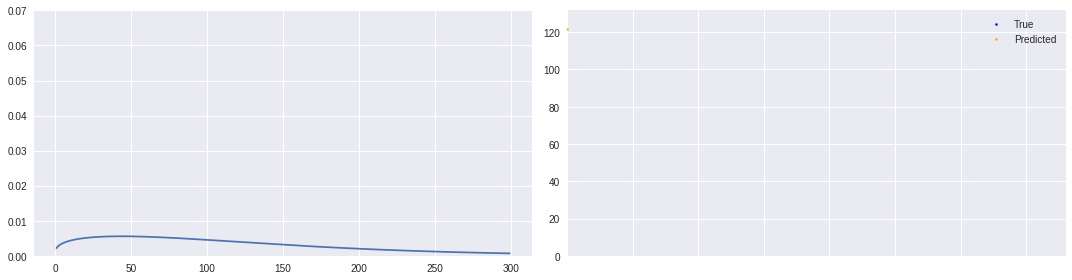

In [36]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.stats import dweibull
print dweibull.interval.__doc__

def pdf_weibull(x, alpha, beta):
    return (alpha/beta)*(x/beta)**(alpha - 1)*np.exp(-(x/beta)**alpha)

machine_id = 1 
lot = train_Y[1]
y_pred_wtte = model.predict(train_X[1].reshape(1, max_batch_len, nb_features))[0]
frames = zip(lot, y_pred_wtte)
freq = 10

# pad, w_pad, h_pad, and rect
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.set_tight_layout(True)

x = np.arange(1,300.)
beta, alpha = y_pred_wtte[0]
line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
i = 0
predict_mean = mean_weibull(alpha, beta)
ax2.plot(i, lot[0], 'bo', label="True", ms=2.5)
ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
ax2.legend(loc="upper right")
# limits
ax1.set_ylim([0, 0.07])
ax2.set_ylim([0, predict_mean + 10])
ax2.set_xlim([0, len(frames)/freq + 2])
ax2.set_xticklabels([])
# acc values
acc_y_true = []
acc_y_pred = []
def update(instant):
    y_true, y_pred = instant
    beta, alpha = y_pred
    # print y_true
    pdf = pdf_weibull(x, alpha, beta)
    line1.set_ydata(pdf)
    global i, acc_y_true, acc_y_pred
    i += 1
    mean = mean_weibull(alpha, beta)
    sigma = np.sqrt(var_weibull(alpha, beta))
    acc_y_pred += [mean]
    acc_y_true += [y_true[0]]
    ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
    # facecolor='blue', alpha=0.5
    ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
    conf = dweibull.interval(0.90, alpha, loc=mean, scale=sigma)
    ax1.set_title("Predicted Weibull Distrib. (Mean: " + "{0:.1f}".format(predict_mean)
                 + ", Std: " + "{0:.1f}".format(sigma) + ")"
                 + " Conf. 90%: [{0:.1f}, {1:.1f}]".format(*conf))
    ax2.set_title("Real RUL: " + str(y_true[0]) + " cycles")
    
fig.set_size_inches(15,4)
print('\n############ Engine ' + str(machine_id) + " ############")
anim = FuncAnimation(fig, update, frames=frames[0::freq])
anim.save("Images/gif1.gif", writer="imagemagick")
plt.close()
from IPython.display import HTML
HTML('<img src="Images/gif1.gif">')

## WTTE RNN

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop
from keras import backend as k
from sklearn.preprocessing import normalize

import tensorflow as tf

"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

"""
    Not used for this model, but included in case somebody needs it
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))


"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

def mean_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.exp(tf.lgamma(1 + 1./alpha)))

def mode_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.pow(tf.div(alpha - 1., alpha), 1./alpha))

def mse_wtte_keras(y_true, y_pred):
    y_true = tf.gather(tf.transpose(y_true), 0)
    y_pred = mean_wtte_keras(y_pred)
    return tf.losses.mean_squared_error(y_true, y_pred)

def r2_wtte_keras(y_true, y_pred):
    """Coefficient of Determination for the output of the WTTE
    """
    y_true = tf.gather(tf.transpose(y_true), 0)
    y_pred = mean_wtte_keras(y_pred)
    return r2_keras(y_true, y_pred)

keras.losses.mean_wtte_keras = mean_wtte_keras
keras.losses.mode_wtte_keras = mode_wtte_keras
keras.losses.mse_wtte_keras = mse_wtte_keras
keras.losses.r2_wtte_keras = r2_wtte_keras

In [0]:
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=1)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=1)

In [0]:
nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
from keras.layers import Masking
model.add(Masking(mask_value=0., input_shape=(sequence_length, nb_features)))

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop',metrics=[r2_wtte_keras, mse_wtte_keras])

print(model.summary())
# validation_data=(test_X, test_Y_)
# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 50, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total para

KeyboardInterrupt: 

In [0]:
!ls Models

regression_model.h5 rnn_1_82.h5         wttwgru_1_35.h5
rnn_1_59.h5         wtte_1_234.h5


In [0]:
from keras.models import load_model
import keras.losses
keras.losses.weibull_loglik_discrete = weibull_loglik_discrete
model = load_model("Models/wtte_1_234.h5", custom_objects={'activate': activate})

/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


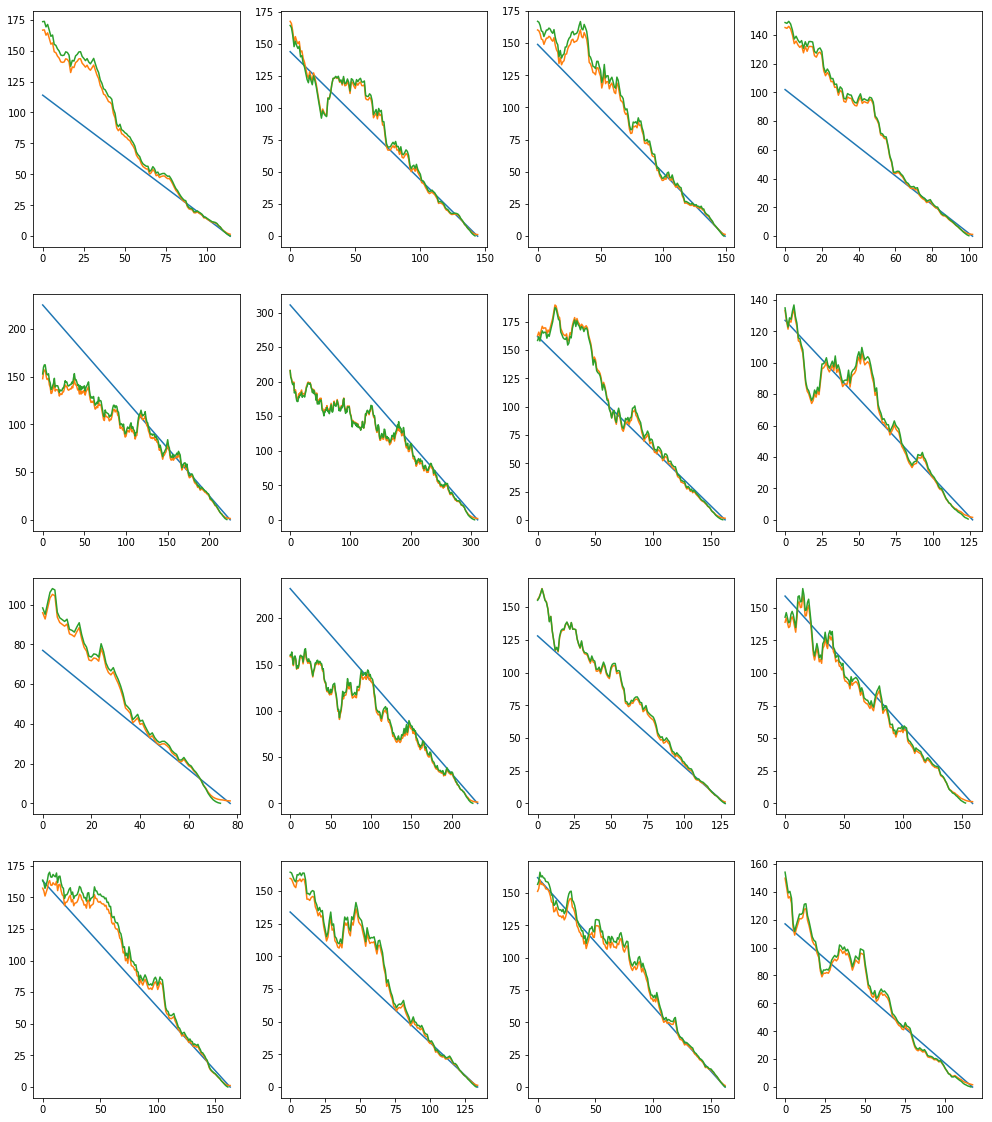

In [0]:
%matplotlib inline

fig = plt.figure()
n_cols=4
i = 1
for id,lot in lot_sample:
    ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
    plt.plot(lot)
    y_pred = model.predict(np.array(seq_gen[id]))
    plt.plot([mean_weibull(alpha, beta) for beta, alpha in y_pred])
    plt.plot([mode_weibull(alpha, beta) for beta, alpha in y_pred])
    i += 1
        
plt.gcf().set_size_inches((17,5*sample_size/n_cols))
# plt.grid(True)
plt.show()

In [0]:
import math

print np.arange(0.7, 2.7 + 1)
np.arange(*map(lambda x: int(np.ceil(x)), [0.7, 2.7]))

[0.7 1.7 2.7]


array([1, 2])

11
(-0.18140736985649908, 2.920514291938332)
(18.608660213954124, 23.323613801059885)
(36.89927870390476, 46.02334828587178)
(49.02265963023316, 66.40562646540262)
(63.176609170697525, 91.9906199549044)
(75.81019921840178, 115.14009662934828)


/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


(0.0, 0.3)

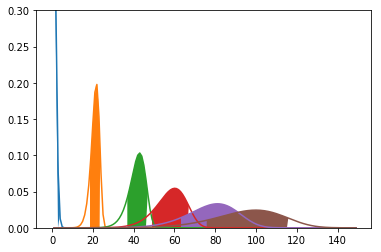

In [0]:
%matplotlib inline

from scipy.stats import dweibull

n_cols=4
i = 1
j = 1
for id,lot in lot_sample[15:16]:
    y_pred = model.predict(np.array(seq_gen[id]))
    print len(y_pred)/10
    for beta, alpha in list(reversed(y_pred))[0::20]:
        # ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
        x = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha, beta)
        #plt.hist(x, bins=100)
        x = np.arange(1,150.)
        plt.plot(x, pdf_weibull(x, alpha, beta))
        mean = mean_weibull(alpha, beta)
        sigma = np.sqrt(var_weibull(alpha, beta))
        # alpha is the shape parameter
        conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
        print conf
        plt.fill([conf[0]] + list(np.arange(conf[0], conf[1]+1)) + [conf[1]], [0] + list(pdf_weibull(np.arange(conf[0], conf[1]+1), alpha, beta)) + [0])
        # plt.gcf().set_size_inches((17,5*sample_size/n_cols))
axes = plt.gca()
axes.set_ylim([0., 0.3])


In [0]:
print dweibull.interval.__doc__


        Confidence interval with equal areas around the median.

        Parameters
        ----------
        alpha : array_like of float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
        arg1, arg2, ... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            location parameter, Default is 0.
        scale : array_like, optional
            scale parameter, Default is 1.

        Returns
        -------
        a, b : ndarray of float
            end-points of range that contain ``100 * alpha %`` of the rv's
            possible values.

        


From matplotlib 2.1 on, we can create an animation using JavaScript. This does not require any video codecs.

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.stats import dweibull
print dweibull.interval.__doc__

machine_id, lot = lot_sample[15]
y_pred_wtte = model.predict(np.array(seq_gen[machine_id]))
frames = zip(lot, y_pred_wtte)
freq = 10

# pad, w_pad, h_pad, and rect
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.set_tight_layout(True)

x = np.arange(1,300.)
beta, alpha = y_pred_wtte[0]
line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
i = 0
predict_mean = mean_weibull(alpha, beta)
ax2.plot(i, lot[0], 'bo', label="True", ms=2.5)
ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
ax2.legend(loc="upper right")
# limits
ax1.set_ylim([0, 0.07])
ax2.set_ylim([0, predict_mean + 10])
ax2.set_xlim([0, len(frames)/freq + 2])
ax2.set_xticklabels([])
# acc values
acc_y_true = []
acc_y_pred = []
def update(instant):
    y_true, y_pred = instant
    beta, alpha = y_pred
    # print y_true
    pdf = pdf_weibull(x, alpha, beta)
    line1.set_ydata(pdf)
    global i, acc_y_true, acc_y_pred
    i += 1
    mean = mean_weibull(alpha, beta)
    sigma = np.sqrt(var_weibull(alpha, beta))
    acc_y_pred += [mean]
    acc_y_true += [y_true[0]]
    ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
    # facecolor='blue', alpha=0.5
    ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
    conf = dweibull.interval(0.90, alpha, loc=mean, scale=sigma)
    ax1.set_title("Predicted Weibull Distrib. (Mean: " + "{0:.1f}".format(predict_mean)
                 + ", Std: " + "{0:.1f}".format(sigma) + ")"
                 + " Conf. 90%: [{0:.1f}, {1:.1f}]".format(*conf))
    ax2.set_title("Real RUL: " + str(y_true[0]) + " cycles")
    
fig.set_size_inches(15,4)
print('\n############ Engine ' + str(machine_id) + " ############")
anim = FuncAnimation(fig, update, frames=frames[0::freq])
anim.save("Images/gif1.gif", writer="imagemagick")
plt.close()
from IPython.display import HTML
HTML('<img src="Images/gif1.gif">')


        Confidence interval with equal areas around the median.

        Parameters
        ----------
        alpha : array_like of float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
        arg1, arg2, ... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            location parameter, Default is 0.
        scale : array_like, optional
            scale parameter, Default is 1.

        Returns
        -------
        a, b : ndarray of float
            end-points of range that contain ``100 * alpha %`` of the rv's
            possible values.

        

############ Engine 22 ############


$\mu = \beta\Gamma(1 + \alpha^{-1})$

$\sigma^2 = \beta^2[\Gamma(1 + 2\alpha^{-1}) - \Gamma^2(1 + \alpha^{-1})]$

$mode = \beta\frac{\alpha-1}{\alpha}^{1/\alpha}$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Visualisation_mode_median_mean.svg/150px-Visualisation_mode_median_mean.svg.png)

In [0]:
from math import gamma
def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha)

def pdf_weibull(x, alpha, beta):
    return (alpha/beta)*(x/beta)**(alpha - 1)*np.exp(-(x/beta)**alpha)

# l = [(mean_weibull(alpha, beta), alpha, beta) for beta, alpha in y_pred_test]
# [(r, m) for m, r in zip(l, y_true_test)]


In [0]:
model.evaluate(train_X, train_Y_wtte, verbose=2)

[3.4126150554372425, 202.72968158681655, 0.8568457137767325]

In [0]:
K.eval(tf.gather(tf.transpose(K.variable(train_Y_wtte)), 0))

array([141., 140., 139., ...,   2.,   1.,   0.], dtype=float32)

In [0]:
hey = model.predict(train_X)

In [0]:
def mode_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.pow(tf.div(alpha - 1., alpha), 1./alpha))

def r2_wtte_keras(y_true, y_pred):
    """Coefficient of Determination for the output of the WTTE
    """
    y_true = tf.gather(tf.transpose(y_true), 0)
    y_pred = tf.cast(mode_wtte_keras(y_pred), tf.float64)
    mask = tf.is_nan(K.square( y_true - y_pred ))
    y_true = tf.boolean_mask(y_true, tf.logical_not(mask))
    y_pred = tf.boolean_mask(y_pred, tf.logical_not(mask))
    return r2_keras(y_true, y_pred)

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
K.eval(r2_wtte_keras(train_Y_wtte, K.variable(hey)))

0.9115362706467771

In [0]:
from scipy.stats import dweibull
print dweibull.interval.__doc__
mean = 3.
sigma = 2.
dweibull.interval(0.90, 2., loc=mean, scale=sigma)


        Confidence interval with equal areas around the median.

        Parameters
        ----------
        alpha : array_like of float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
        arg1, arg2, ... : array_like
            The shape parameter(s) for the distribution (see docstring of the
            instance object for more information).
        loc : array_like, optional
            location parameter, Default is 0.
        scale : array_like, optional
            scale parameter, Default is 1.

        Returns
        -------
        a, b : ndarray of float
            end-points of range that contain ``100 * alpha %`` of the rv's
            possible values.

        


(-0.03485425877029291, 6.0348542587702925)

In [0]:
K.eval(r2_wtte_keras(K.variable(train_Y_wtte), K.variable(model.predict(train_X))))

nan

In [0]:
y_pred_train = model.predict(train_X)

In [0]:
type(np.nan)

float

In [0]:
print len([mode_weibull(alpha, beta) for beta, alpha in y_pred_train])
[mode_weibull(alpha, beta) for beta, alpha in y_pred_train if np.isnan(mode_weibull(alpha, beta))]

/anaconda2/envs/ALL_BF/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


15631


[nan]

[4.229504462211363, 374.55462843371976, 0.8215564880319821]

RMSE: 21.093037133

R^2: 0.73569892864

Train:

RMSE: 24.0392942742

R^2: 0.82301705261


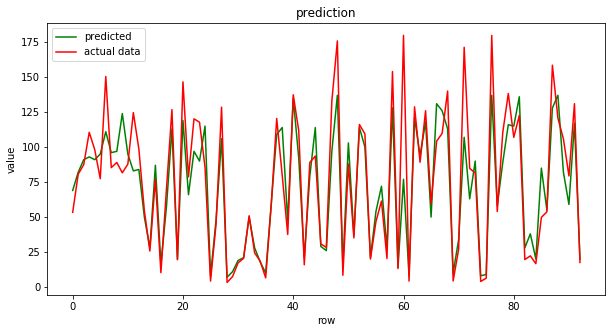

In [0]:
# test metrics
scores_test = model.evaluate(test_X, test_Y_wtte, verbose=2)
print scores_test
import math
# print('\nRMSE: {}'.format(math.sqrt(scores_test[2])))
# print('\nR^2: {}'.format(scores_test[1]))

y_pred_test = model.predict(test_X)
y_pred_test = [mean_weibull(alpha, beta) for beta, alpha in y_pred_test]
y_true_test = test_Y_wtte.T[0]

from sklearn.metrics import mean_squared_error
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_test, y_pred_test))))
print('\nR^2: {}'.format(r2_score(y_true_test, y_pred_test)))

y_pred_train = model.predict(train_X)
y_pred_train = [mean_weibull(alpha, beta) for beta, alpha in y_pred_train]
y_true_train = train_Y_wtte.T[0]

print "\nTrain:"
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_train, y_pred_train))))
print('\nR^2: {}'.format(r2_score(y_true_train, y_pred_train)))

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index=None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_true_test, color="green")
plt.plot(y_pred_test, color="red")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [0]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print r2_score(y_true, y_pred)
K.eval(r2_keras(K.variable(y_true), K.variable(y_pred)))

0.9486081370449679


0.94860816

In [0]:
y_pred = model.predict(train_X)

Inverse CDF $ = \beta (-\log(1 - x))^\frac{1}{\alpha} $ when $ 0<x<1 $

6.928095 6.4536257
Mean: 6.037190102043358 6.03371582899
Variance: 1.0604312485179463 1.04767931626
Max: 8.891407073516358

9.819332 79.735016
Mean: 75.92631120330188 75.7970325855
Variance: 85.21369489947746 86.0707345473
Max: 98.44802440214987

5.46 157.85419
Mean: 145.65311721767503 145.670765166
Variance: 971.2926274150275 947.646743976
Max: 229.53323841657405


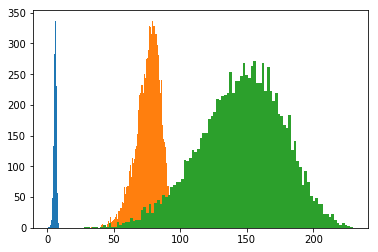

In [0]:
def inverse_cdf_weibull(x, alpha, beta):
    return beta*np.power((-np.log(1.-x)), 1./alpha)

alpha, beta = 6.4536257, 6.928095

alpha1, beta1 = 79.735016, 9.819332

alpha2, beta2 = 157.85419, 5.46

alpha, beta = beta, alpha
alpha1, beta1 = beta1, alpha1
alpha2, beta2 = beta2, alpha2

x = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha, beta)
x1 = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha1, beta1)
x2 = inverse_cdf_weibull(np.random.uniform(0,1,10000), alpha2, beta2)

print alpha, beta
print "Mean:", np.mean(x), mean_weibull(alpha, beta)
print "Variance:", np.var(x), var_weibull(alpha, beta)
print "Max:", np.max(x)

print "\n", alpha1, beta1
print "Mean:", np.mean(x1), mean_weibull(alpha1, beta1)
print "Variance:", np.var(x1), var_weibull(alpha1, beta1)
print "Max:", np.max(x1)

print "\n", alpha2, beta2
print "Mean:", np.mean(x2), mean_weibull(alpha2, beta2)
print "Variance:", np.var(x2), var_weibull(alpha2, beta2)
print "Max:", np.max(x2)

plt.hist(x, bins=100)
plt.hist(x1, bins=100)
plt.hist(x2, bins=100)
plt.show()

In [0]:
10**np.log10(100)

100.0

In [0]:
import tensorflow as tf

def mean_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.exp(tf.lgamma(1 + 1./alpha)))

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha)

def mode_wtte_keras(y_pred):
    beta = tf.gather(tf.transpose(y_pred), 0)
    alpha = tf.gather(tf.transpose(y_pred), 1)
    return tf.multiply(beta, tf.pow(tf.div(alpha - 1., alpha), 1./alpha))

print K.eval(mean_wtte_keras(K.variable(model.predict(test_X))))
print K.eval(mode_wtte_keras(K.variable(model.predict(test_X))))

array([ 56.276646 ,  67.6662   ,  71.69847  ,  96.62592  , 109.40476  ,
        89.83319  , 169.9006   ,  75.797035 ,  91.76934  ,  90.29632  ,
        83.7522   ,  99.04816  ,  87.112305 ,  45.005672 ,  30.165201 ,
        69.40536  ,  14.719038 ,  66.60054  , 117.768036 ,  19.09594  ,
       148.8167   ,  67.25212  , 105.89647  , 113.4988   ,  86.981186 ,
         3.0345056,  44.55659  , 145.6757   ,   6.0337157,  15.312067 ,
        21.644724 ,  19.5122   ,  60.950836 ,  29.884735 ,  17.206484 ,
         8.820916 ,  78.13589  , 134.82016  , 110.103806 ,  39.952538 ,
       161.03484  , 138.08713  ,  22.126017 ,  75.357414 ,  91.86031  ,
        32.500282 ,  28.563864 , 102.4442   , 239.50926  ,  10.580019 ,
        96.36856  ,  48.572124 , 104.841255 , 104.603065 ,  22.690699 ,
        59.3872   ,  68.21561  ,  23.432127 , 181.14598  ,  12.968246 ,
       198.90607  ,   5.0016236, 129.12852  ,  93.4095   , 148.28484  ,
        56.014812 ,  96.828316 , 110.69471  , 108.69264  ,   7.4

In [0]:
def mse_wtte_keras(y_true, y_pred):
    y_true = mean_wtte_keras(y_pred)
    y_pred = tf.gather(tf.transpose(y_pred), 0)
    return tf.losses.mean_squared_error(y_true, y_pred)

In [0]:
def r2_wtte_keras(y_true, y_pred):
    """Coefficient of Determination for the output of the WTTE
    """
    y_pred = mean_weib_keras(y_pred)
    y_true = tf.gather(tf.transpose(y_true), 0)
    return r2_keras(y_true, y_pred)

In [0]:
K.eval( K.print_tensor(mse_wtte_keras(K.variable(train_Y_wtte), K.variable(model.predict(train_X))), message="Hey="))

59.43628

## Giancarlo (GRU)

In [0]:
import wtte.weibull as weibull
import wtte.wtte as wtte

from keras.layers import GRU
from keras.layers import Lambda
from keras.optimizers import adam

from wtte.wtte import WeightWatcher

import keras.backend as K
K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

tte_mean_train = np.nanmean(train_Y_wtte[:,0])
mean_u = np.nanmean(train_Y_wtte[:,0])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)


nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

# Start building our model
model = Sequential()


# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))

# model.add(Dense(20))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# Apply the custom activation function mentioned above
# model.add(Activation(activate))

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5), metrics=[r2_wtte_keras, mse_wtte_keras])

history = model.fit(train_X, train_Y_wtte, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [WeightWatcher(),
                       keras.callbacks.TerminateOnNaN(),
                       keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


('epsilon', 1e-10)
('tte_mean_train', 84.4561448403813, 'init_alpha: ', 1.0059086179417465, 'mean uncensored train: ', 84.4561448403813)
Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 6s - loss: 6.3082 - r2_wtte_keras: -2.0879e+05 - mse_wtte_keras: 684503326.1255 - val_loss: 5.3630 - val_r2_wtte_keras: -4.2839e-01 - val_mse_wtte_keras: 3190.5389
Epoch 2/100
 - 4s - loss: 5.3013 - r2_wtte_keras: 0.1050 - mse_wtte_keras: 2907.8977 - val_loss: 5.0781 - val_r2_wtte_keras: 0.1380 - val_mse_wtte_keras: 1878.3918
Epoch 3/100
 - 4s - loss: 4.9289 - r2_wtte_keras: 0.4945 - mse_wtte_keras: 1643.4619 - val_loss: 4.9318 - val_r2_wtte_keras: -5.2076e-02 - val_mse_wtte_keras: 1812.3027
Epoch 4/100
 - 4s - loss: 4.7289 - r2_wtte_keras: 0.6084 - mse_wtte_keras: 1273.9327 - val_loss: 4.7468 - val_r2_wtte_keras: 0.1241 - val_mse_wtte_keras: 1535.5110
Epoch 5/100
 - 5s - loss: 4.5864 - r2_wtte_keras: 0.6691 - mse_wtte_keras: 1077.3323 - val_loss: 4.5838 - val_r2_wtte_keras: 0.4633 - val_m

In [0]:
model.save("wttwgru_1_35.h5")

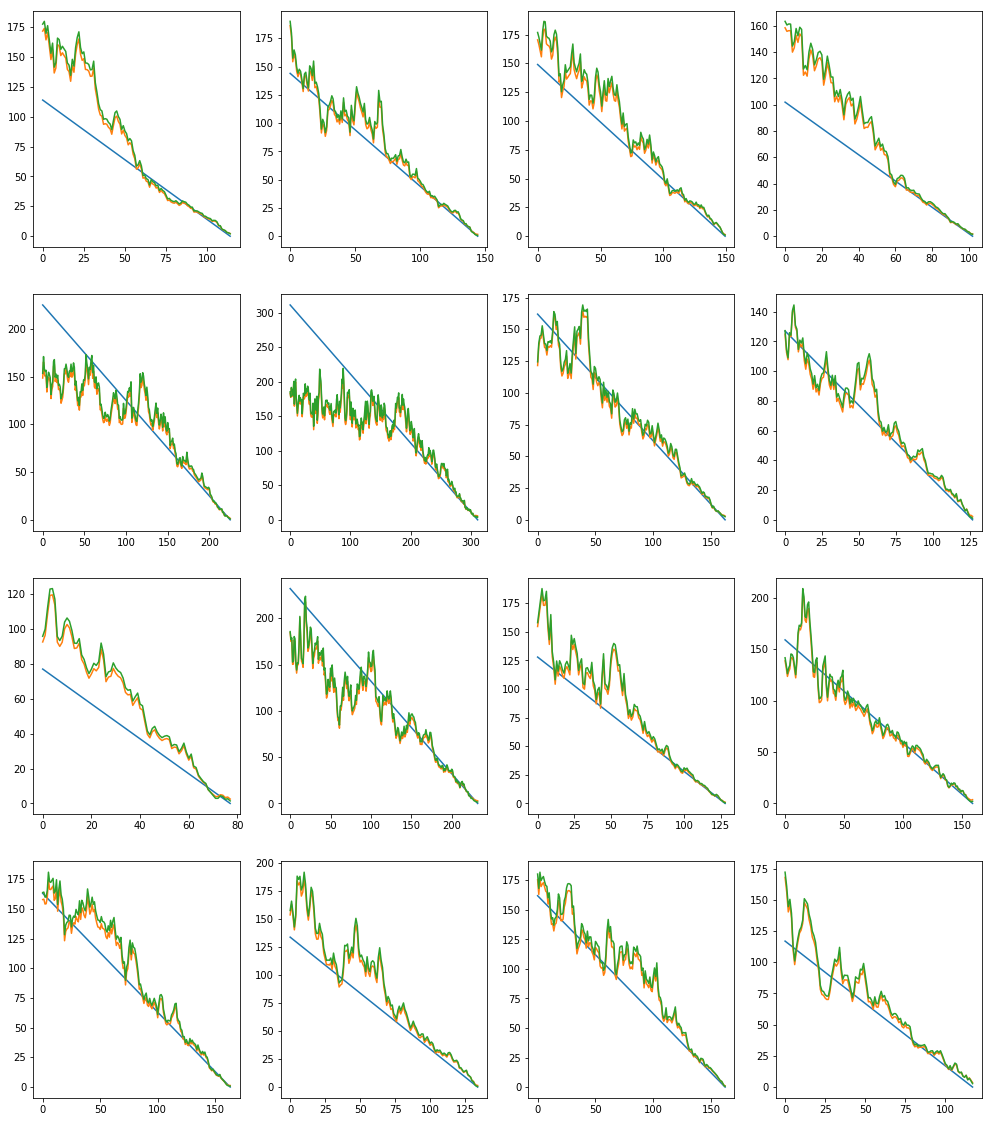

In [0]:
%matplotlib inline

fig = plt.figure()
n_cols=4
i = 1
for id,lot in lot_sample:
    ax = fig.add_subplot(sample_size/n_cols,n_cols,i)
    plt.plot(lot)
    y_pred = model.predict(np.array(seq_gen[id]))
    plt.plot([mean_weibull(alpha, beta) for beta, alpha in y_pred])
    plt.plot([mode_weibull(alpha, beta) for beta, alpha in y_pred])
    i += 1
        
plt.gcf().set_size_inches((17,5*sample_size/n_cols))
# plt.grid(True)
plt.show()

[3.941347009392195, 0.7301350594848715, 442.3439199796287]

RMSE: 21.0319732355

R^2: 0.737227005611

Train:

RMSE: 24.2345422178

R^2: 0.82013045479


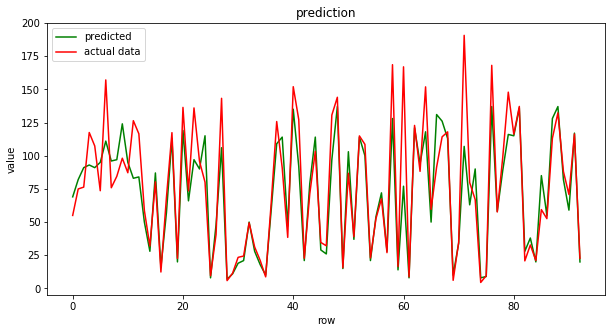

In [0]:
# test metrics
scores_test = model.evaluate(test_X, test_Y_wtte, verbose=2)
print scores_test
import math
# print('\nRMSE: {}'.format(math.sqrt(scores_test[2])))
# print('\nR^2: {}'.format(scores_test[1]))

y_pred_test = model.predict(test_X)
y_pred_test = [mean_weibull(alpha, beta) for beta, alpha in y_pred_test]
y_true_test = test_Y_wtte.T[0]

from sklearn.metrics import mean_squared_error
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_test, y_pred_test))))
print('\nR^2: {}'.format(r2_score(y_true_test, y_pred_test)))

y_pred_train = model.predict(train_X)
y_pred_train = [mean_weibull(alpha, beta) for beta, alpha in y_pred_train]
y_true_train = train_Y_wtte.T[0]

print "\nTrain:"
print('\nRMSE: {}'.format(math.sqrt(mean_squared_error(y_true_train, y_pred_train))))
print('\nR^2: {}'.format(r2_score(y_true_train, y_pred_train)))

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index=None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_true_test, color="green")
plt.plot(y_pred_test, color="red")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")